# Predictive Maintenace With Prognostics and Health Management

# Import Libraries
Nesse projeto são utilizadas as principais bibliotecas de manipulação de dados, aprendizagem de máquina e deep learning, como <i>Pandas</i>, <i>Numpy</i>, <i>SkLearn</i> e <i>Keras</i> além de bibliotecas para vizualisação de dados.

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import plotly as py
import seaborn as sb

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras import callbacks

Using TensorFlow backend.


# Preparing DataFrame 

## Load Data
Os conjuntos de dados utilizados possuem 26 varáveis que consistem em várias séries temporais multivariadas. Cada conjunto de dados é dividido em subconjuntos de treinamento e teste.<br>
Os dados são fornecidos como arquivos de texto com colunas de números, separados por espaços. Cada linha é um instantância dos dados obtidos durante um único ciclo operacional. 

In [3]:
def loadData(path_, sep_=' ', header_=None):
    
    #load the dataframe
    dataFrame = pd.read_csv(path_, sep=sep_, header=header_) 
    
    #Create an array with the name of the features
    columnsName = ["id", "cycle", "settings1", "settings2", "settings3"] 
    [columnsName.append("sensor"+str(x)) for x in range(1,22)];
    
    #Drop extra columns with NaN values
    dataFrame = dataFrame.drop([26, 27], axis=1)
    
    #Set the dataframe columns name
    dataFrame.columns = columnsName
    
    #Copy Cycle
    dataFrame['nCycle'] = dataFrame['cycle']
    
    return dataFrame

def loadRUL(path_, sep_=' ', header_=None):
    
    dataFrame = pd.read_csv(path_, sep=sep_, header=header_)

    dataFrame = dataFrame.drop(1, axis=1)
    
    dataFrame.columns = ['real']
    
    dataFrame['id'] = dataFrame.index + 1

    return dataFrame

def classification(dataFrame, cRul = 1):
        
    #Calculate the Max Cycle before failure of a engine and the Remaining Useful Life of each instance
    if cRul == 1:   #Calculate the RUL If needed
        dataFrame['max_cycle'] = dataFrame.groupby(['id'], sort=False)['cycle'].transform(max)
        dataFrame['RUL'] = dataFrame['max_cycle']-dataFrame['cycle']
    
    
    #Set the classification of RUL
    conditions = [
    (dataFrame['RUL'] > 30),
    (dataFrame['RUL'] <= 30),]
 
    classification = [0, 1] #0 Running State  #Maitenance State

    dataFrame['classification']= np.select(conditions, classification)
    
    return dataFrame

In [4]:
#Load Data - HPC Degradation - Sea Level
trainDataSet = loadData('CMAPSSData//train_FD001.txt') #Train Dataset
testDataSet = loadData('CMAPSSData//test_FD001.txt') #Test Dataset
rulDataSet = loadRUL('CMAPSSData//RUL_FD001.txt') #Remaining Useful Life Data

### Data Summary ###
A seguir vemos o resumo do conjunto de dados, com informações de contagem, média, desvio padrão, valores máximos e mínimos, etc. Através desses dados é possível verificar se existem outliers ou anomalias.

In [5]:
trainDataSet.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
settings1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
settings2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
settings3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


## Cleaning Data ##
Os sensores que não apresentarãlo mudança no tempo foram removidos do conjunto de dados.

In [6]:
# Drop sensors with no change in time
dropColumns = ['settings3', 'sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']

sample = trainDataSet.loc[trainDataSet['id'] == 1]   #Chose Engine 01 as sample

trainDataSet = trainDataSet.drop(dropColumns, axis=1)
testDataSet = testDataSet.drop(dropColumns, axis=1)
sample  = sample.drop(dropColumns, axis=1)

### Visualization of the Data ###
Representação gráfica dos dados de treinamento.

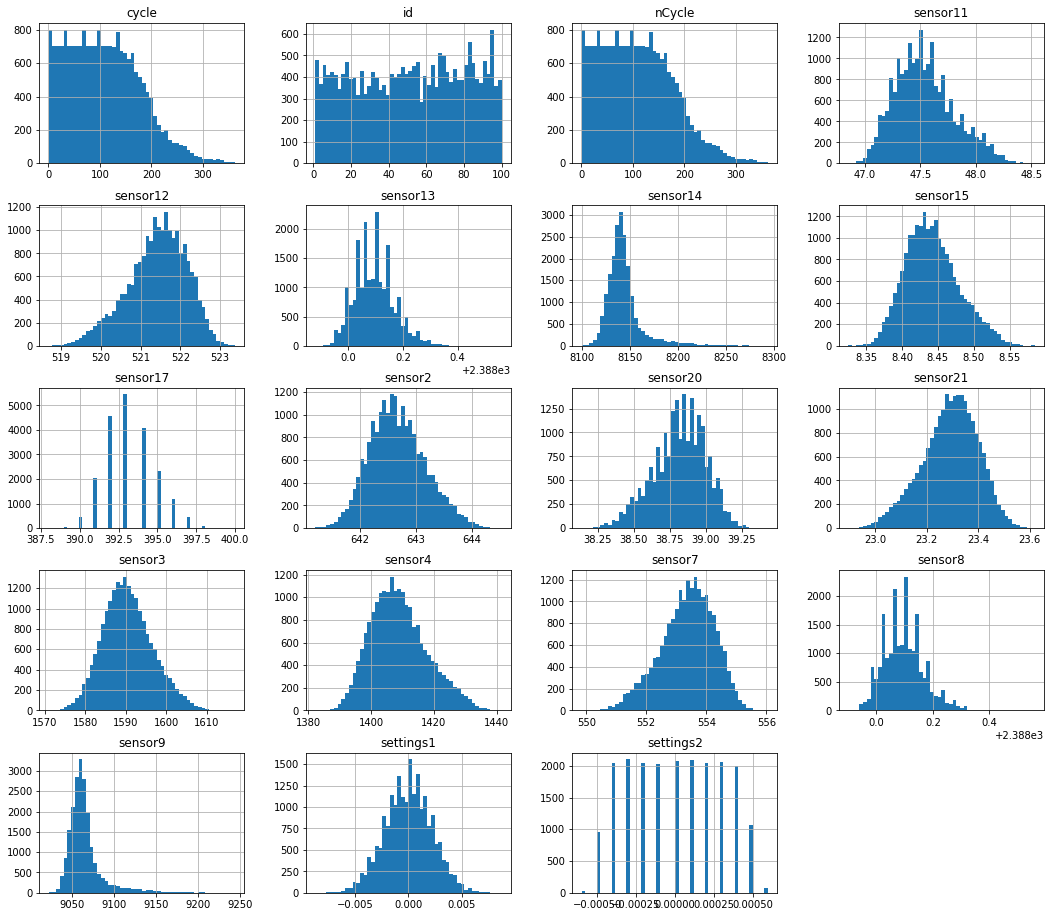

In [7]:
trainDataSet.hist(bins=50, figsize=(18,16))
plt.show()

### Settings of the TurboFan ###
Cada turbina opera sob certas configurações que mudam a cada ciclo, ou voo, conforme mostrado abaixo. A configuração 3 é constante, ou seja, não sofre alterações no tempo.

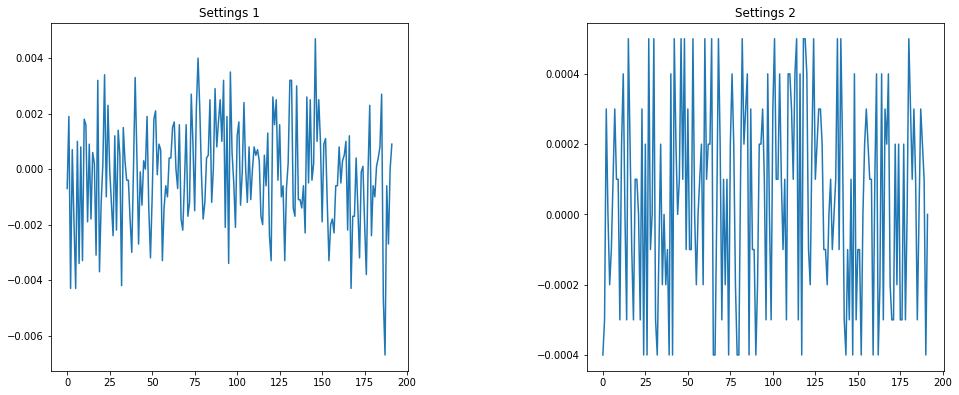

In [8]:
plt.figure(1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2,2,1)
sample['settings1'].plot(figsize=(16, 16), title='Settings 1') 

plt.subplot(2,2,2)
sample['settings2'].plot(figsize=(16, 16), title='Settings 2') 

### Plot Sample Sensor Data (With Noise) ###
A degradação do <b>Compressor de Alta Pressão (HPC)</b> da turbina número 1 no tempo pode ser vista através da plotagem de suas váriaveis. Nem todos os sensores sofrem alteração no tempo, então podem ser removidos da análise. De acordo com os autores da simulação, os dados dos sensores possuem ruídos, o que deve ser tratado através de métodos de remoção ou suavização de sinais.

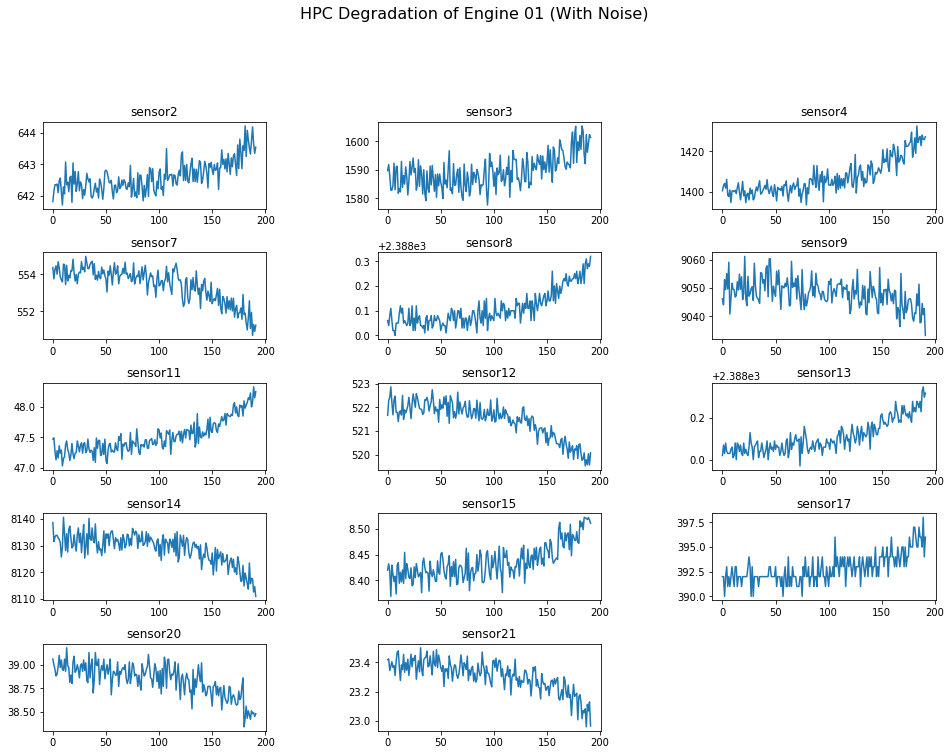

In [9]:
# Plot Sample Data
plt.figure(1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(4,18):
    plt.subplot(7,3,i-3)
    sample[sample.columns.values[i]].plot(figsize=(16, 16), title=sample.columns.values[i]) 
    
plt.suptitle('HPC Degradation of Engine 01 (With Noise)', fontsize=16);

## Smoth Data ##
Para remoção do ruído dos dados foi utilizado um filtro passa-baixas. A <b>média móvel</b> é um estimador calculado a partir de uma série de médias de diferentes amostras da população. [Wikipedia] <br> Os dados foram também normalizados para mesma escala, utilizando o escalar Min-Max.

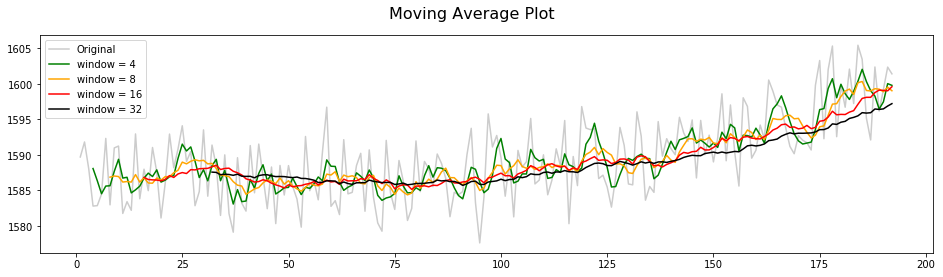

In [12]:
#Moving average
t_data = trainDataSet.loc[trainDataSet['id'] == 1]
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(t_data.cycle, t_data.sensor3, c='gray', alpha=0.4, label='Original')
ax.plot(t_data.cycle, t_data.sensor3.rolling(window=4).mean(), c='green', alpha=1, label='window = 4')
ax.plot(t_data.cycle, t_data.sensor3.rolling(window=8).mean(), c='orange', alpha=1, label='window = 8')
ax.plot(t_data.cycle, t_data.sensor3.rolling(window=16).mean(), c='red', alpha=1, label='window = 16')
ax.plot(t_data.cycle, t_data.sensor3.rolling(window=32).mean(), c='black', alpha=1, label='window = 32')
plt.suptitle('Moving Average Plot', fontsize=16);
plt.legend()

In [13]:
def reprocessing(dataFrame, i, j):
    
    nColumns = len(dataFrame.columns)
    
    # Remove Noise - Moving Average
    pData = dataFrame[dataFrame.columns[i:j]].rolling(window=4, min_periods=1).mean()
    
    # Data normalization - Min Max
    minMax = preprocessing.MinMaxScaler()
    normTrainData = pd.DataFrame(minMax.fit_transform(pData), columns=pData.columns, index=pData.index)
    
    # Rebuilt dataframe
    pData = pd.concat([dataFrame[dataFrame.columns[0:i]], normTrainData], axis=1)
    pData = pd.concat([pData, dataFrame[dataFrame.columns[j:nColumns]]], axis=1)
    
    return pData

## Preparing Train Data ##
O conjunto de dados de treinamento é preparado através das funções de classificação e reprocessamento dos dados.

In [14]:
trainDataSet = classification(trainDataSet)

In [15]:
trainData = reprocessing(trainDataSet, 4, 19)

## Preparing Test Data ##
O conjunto de dados de teste é reprocessado e mesclado com o conjuntos de dados RUL (Remaining Useful Life), que é o tempo real de vida restante de cada turbina do conjunto de dados de teste. 

In [16]:
testData = reprocessing(testDataSet, 4, 19)

In [17]:
# Prepare RUL data for merge with test data
rul = pd.DataFrame(testData.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rulDataSet['max'] = rul['max'] + rulDataSet['real']
rulDataSet.drop('real', axis=1, inplace=True)

In [18]:
#Defining RUL to the test set
testData = testData.merge(rulDataSet, on=['id'], how='left')
testData['RUL'] = testData['max'] - testData['cycle']
testData.drop('max', axis=1, inplace=True)

In [19]:
testData = classification(testData,0)

### Plot Sample Sensor Data (Without Noise) ###
Visualização dos dados de cada sensor sem ruídos. Os sensores que não variavam no tempo durante os voos foram removidos.

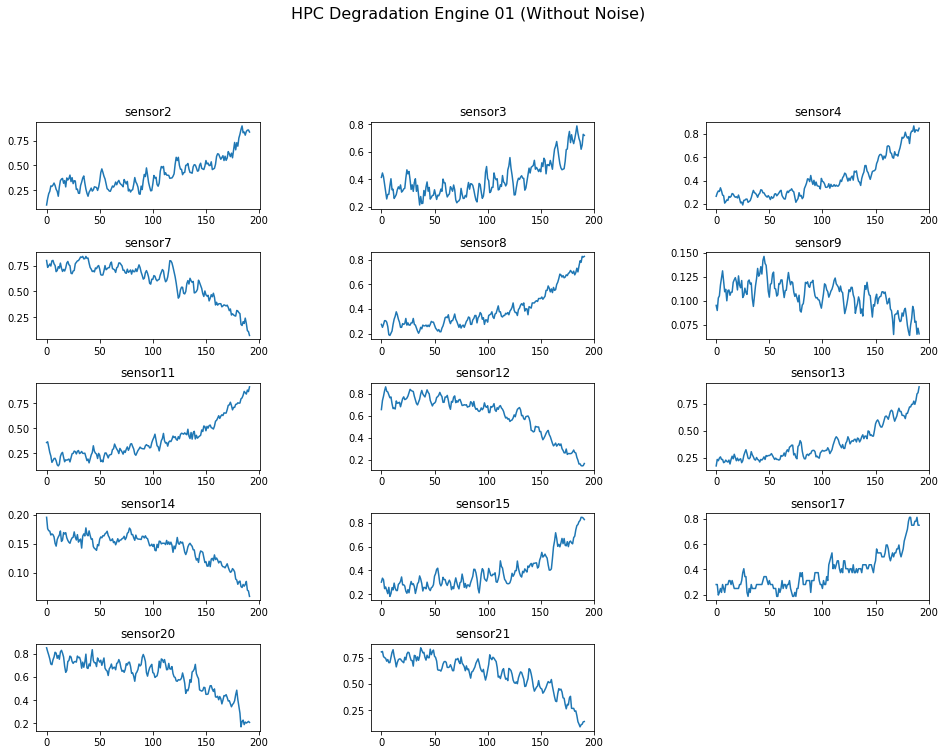

In [20]:
# Sample data without noise
sample = trainData.loc[trainData['id'] == 1]   #Chose Engine 01 as sample

plt.figure(1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(5,19):
    plt.subplot(7,3,i-4)
    sample[sample.columns.values[i-1]].plot(figsize=(16, 16), title=sample.columns.values[i-1]) 

plt.suptitle('HPC Degradation Engine 01 (Without Noise)', fontsize=16);

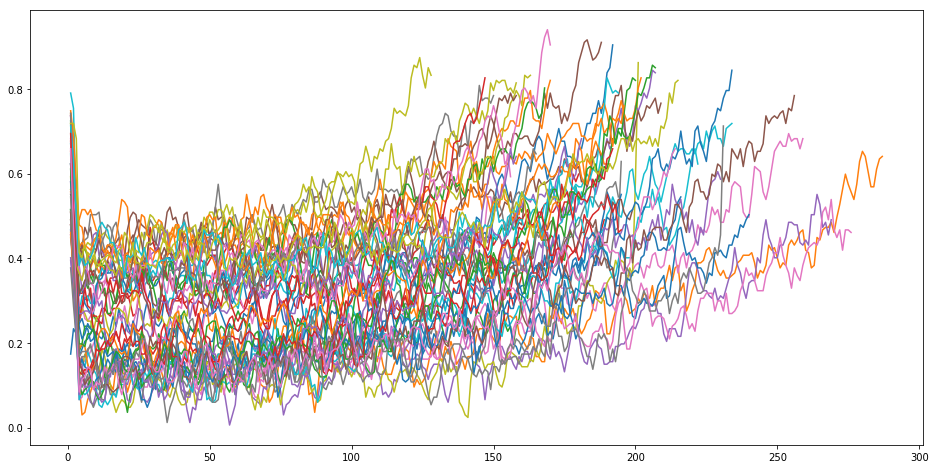

In [60]:
# Plot of sensor 13 and 50 units
plt.figure(figsize = (16, 8))
for i in range(1,50):
    plt.plot(trainData.loc[trainData['id'] == i].cycle, trainData.loc[trainData['id'] == i].sensor13)

### Scatter Plot ###
O gráfico de disperção mostra os dados dos sensores para todas as 50 turbinas do conjunto de dados. Os pontos em <b>Cinza</b> mostra que a saúde do equipamento está em uma zona segura, já os pontos em <b>Amarelo</b> mostram que o equipamento está na <b>Zona de Atenção</b> faltando menos de 30 ciclos para falha.

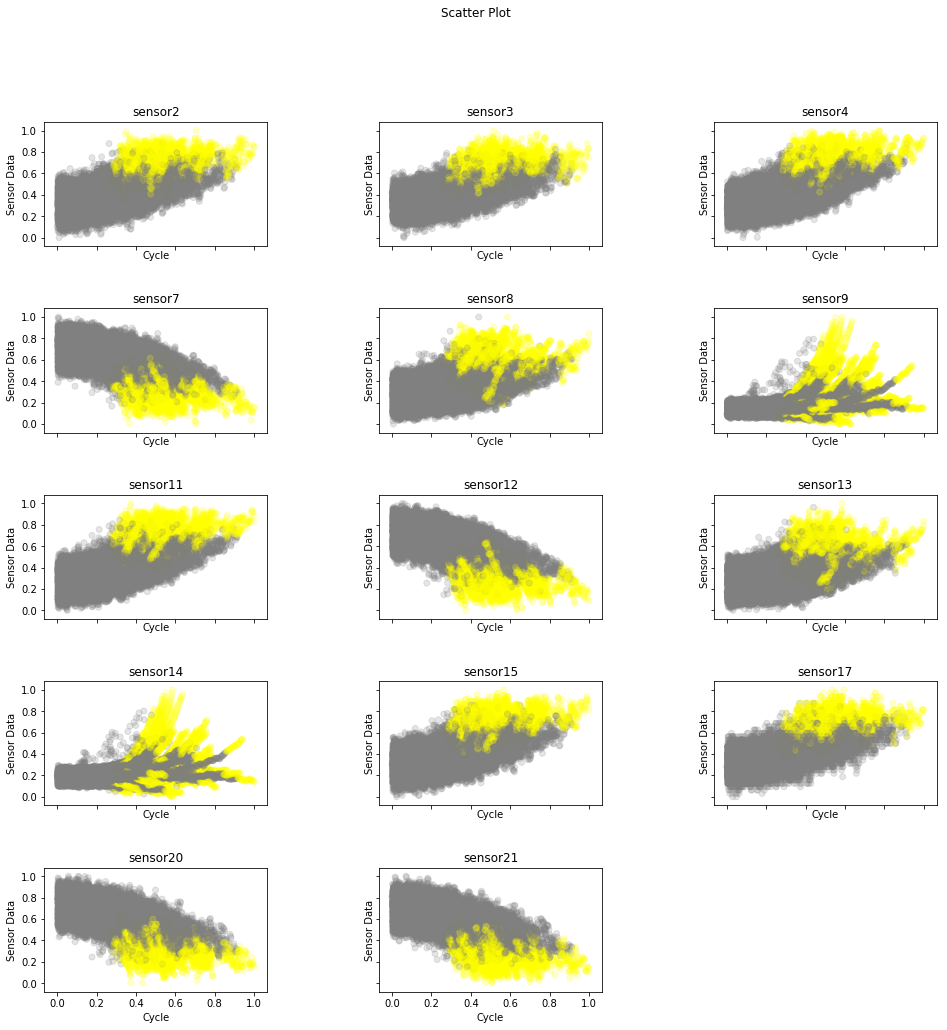

In [61]:
fig, ax_array = plt.subplots(5,3, sharex=True, sharey=True, figsize=(16,16))
fig.suptitle('Scatter Plot')
fig.subplots_adjust(wspace=0.5, hspace=0.5)
idx = 4
colors = np.array(["gray", "yellow"])

for i in range(0,5):
    for j in range(0,3):
        if idx < 18: 
            ax_array[i,j].scatter(trainData['nCycle'], trainData[trainData.columns[idx]], c=colors[trainData['classification']],alpha=0.2)
            ax_array[i,j].set_xlabel(r'Cycle')
            ax_array[i,j].set_ylabel(r'Sensor Data')
            ax_array[i,j].set_title(trainData.columns[idx])
        idx = idx+1
fig.delaxes(ax_array[4][2])
plt.show()

### Correlation Matrix ###

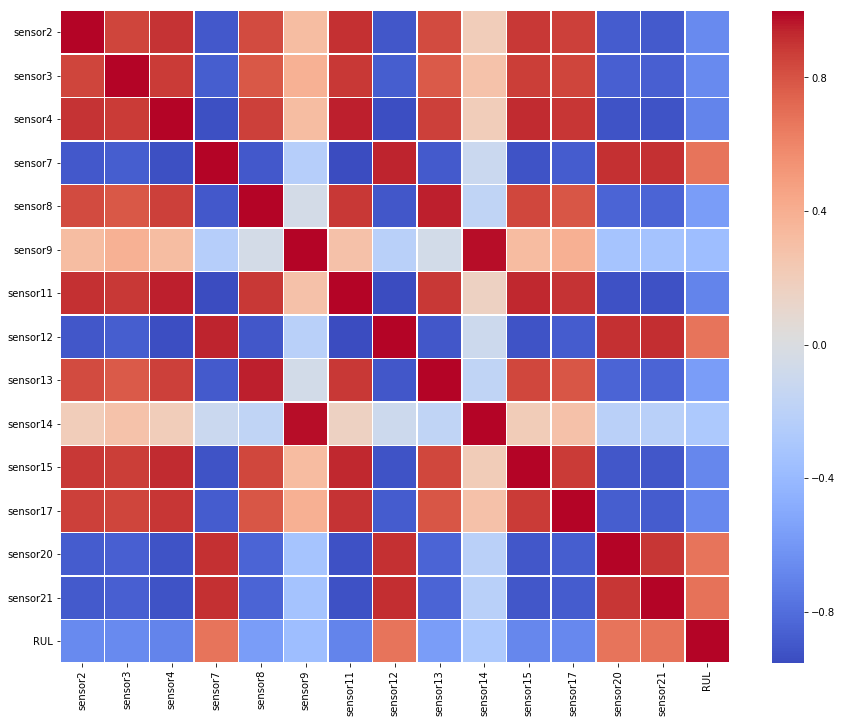

In [62]:
corrDataSet = pd.concat([trainData[trainData.columns[4:18]],trainData['RUL']], axis=1).corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,12))
sb.heatmap(corrDataSet,linewidths=.5, cmap='coolwarm')
plt.show()

### Sensor Data Against RUL ###
Através da plotagem da variação na leitura dos sensores contra o tempo de vida restante da turbina podemos ver a relação entre as váriaveis.

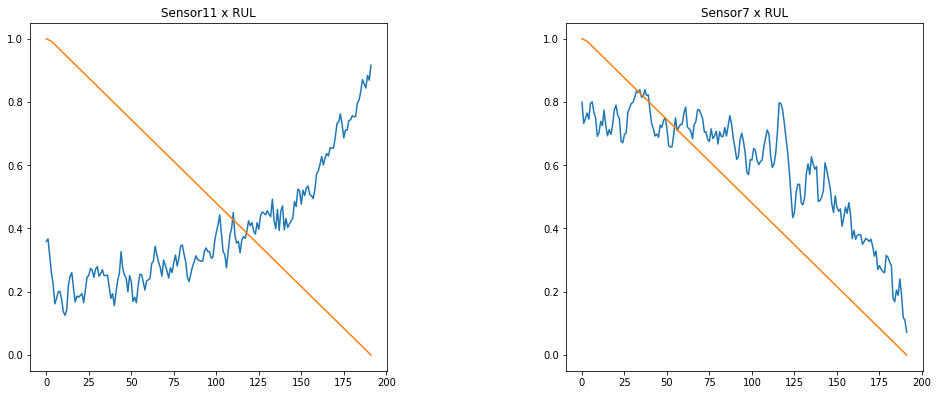

In [63]:
sample = reprocessing(sample, 20, 21)

plt.figure(1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2,2,1)
sample['sensor11'].plot(figsize=(16, 16)) 
sample['RUL'].plot(figsize=(16, 16), title='Sensor11 x RUL') 

plt.subplot(2,2,2)
sample['sensor7'].plot(figsize=(16, 16)) 
sample['RUL'].plot(figsize=(16, 16), title='Sensor7 x RUL') 

### Principle Components Analysis (PCA)

In [64]:
pca = PCA(n_components=2)
rData = pca.fit_transform(trainDataSet[trainDataSet.columns[5:18]]);

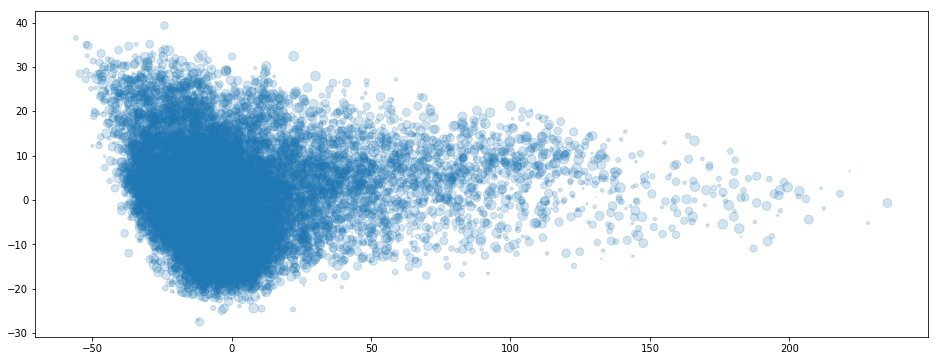

In [65]:
rng = np.random.RandomState(0)
colors = rng.rand(2)
sizes = 100 * rng.rand(100)

fig, ax = plt.subplots(figsize=(16,6))

plt.scatter(rData[:,0], rData[:,1], alpha=0.2,
            s=sizes, cmap='viridis')

## Recurrent Neural Network ##
A parte mais atraente da utilização de <b>Deep Learning</b> no domínio da manutenção preditiva é o fato de que essas redes neurais podem extrair automaticamente as melhores características dos dados, eliminando a necessidade de se fazer <i>feature engineering</i> manual dos recursos.

### Reshaping Data ###
As camadas da Rede Neural Recorrente LSTM da biblioteca <i>Keras</i> esperam uma entrada de um <i>NumPy</i> array de 3 dimensões com as seguintes informações: <b>Amostras</b>(samples) que é o número de sequencias do treinamento, <b>etapas de Tempo</b>(Time Steps) que é o tamanho da sequência, ou janela de visão (look back window) e as <b>características</b>(features), que é o número de características de cada sequência em cada etapa de tempo. As funções a seguir transformam o Data Frame da biblioteca <i>Pandas</i> em arrays compatíveis com a bibliteca <i>Keras</i>.

In [66]:
#Larger window for 50 Cycles or Flights
windowSize = 50

In [67]:
# Reshape features into (samples, time steps, features) 
def genSequence(dfIds, seqLength, seqFeatures):
    dataArr = dfIds[seqFeatures].values
    numElements = dataArr.shape[0]
    for begin, end in zip(range(0, numElements-seqLength), range(seqLength, numElements)):
        yield dataArr[begin:end, :]

# Generate classification
def genClassification(dfIds, seqLength, classification):
    dataArr = dfIds[classification].values
    numElements = dataArr.shape[0]
    return dataArr[seqLength:numElements, :]

In [68]:
#Select features
exceptFeatures = ['id', 'cycle', 'max_cycle', 'RUL', 'classification']
seqFeatures = trainData[trainData.columns.difference(exceptFeatures)].columns

In [69]:
# generate sequences
sequence = (list(genSequence(trainData[trainData['id']==id], windowSize, seqFeatures)) 
           for id in trainData['id'].unique())

In [70]:
# generate classification labels
classGen = [genClassification(trainData[trainData['id']==id], windowSize, ['classification']) 
             for id in trainData['id'].unique()]

In [71]:
# Merge results
seqArray = np.concatenate(list(sequence)).astype(np.float32)
classArray = np.concatenate(classGen).astype(np.float32)

nFeatures = seqArray.shape[2]
nOut = classArray.shape[1]

### RNN LSTM ###
A seguir o modelo de uma rede neural recorrente LSTM é criada. A primeira camada é uma camada LSTM com 100 unidades, seguida por outra camada tamém LSTM com 50 unidades. O dropout é aplicado após cada camada LSTM para controlar overfitting. A camada final é uma camada de saída Densa com ativação de sigmóidal, pois esse é um problema de classificação binária.

In [72]:
#Bulding the Model
model = Sequential()

model.add(LSTM(input_shape=(windowSize, nFeatures), units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nOut, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary()) #Summay of the bulted model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           47200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 77,451
Trainable params: 77,451
Non-trainable params: 0
_________________

In [73]:
# fitting the network
history = model.fit(seqArray, classArray, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Instructions for updating:
Use tf.cast instead.
Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 193s 13ms/step - loss: 0.2532 - acc: 0.8927 - val_loss: 0.0931 - val_acc: 0.9847
Epoch 2/10
14849/14849 [==============================] - 48s 3ms/step - loss: 0.1056 - acc: 0.9570 - val_loss: 0.0594 - val_acc: 0.9795
Epoch 3/10
14849/14849 [==============================] - 53s 4ms/step - loss: 0.0786 - acc: 0.9675 - val_loss: 0.0546 - val_acc: 0.9808
Epoch 4/10
14849/14849 [==============================] - 59s 4ms/step - loss: 0.0721 - acc: 0.9692 - val_loss: 0.0439 - val_acc: 0.9821
Epoch 5/10
14849/14849 [==============================] - 53s 4ms/step - loss: 0.0617 - acc: 0.9733 - val_loss: 0.0422 - val_acc: 0.9885
Epoch 6/10
14849/14849 [==============================] - 58s 4ms/step - loss: 0.0709 - acc: 0.9702 - val_loss: 0.0346 - val_acc: 0.9847
Epoch 7/10
14849/14849 [==============================] - 58s 4ms/step - loss: 0

In [74]:
# Evaluation of the model
scores = model.evaluate(seqArray, classArray, verbose=1, batch_size=200)

15631/15631 [==============================] - 22s 1ms/step


In [75]:
# Confusion Matrix
y_pred = model.predict_classes(seqArray,verbose=1, batch_size=200)
y_true = classArray
cMatrix = confusion_matrix(y_true, y_pred)

15631/15631 [==============================] - 36s 2ms/step


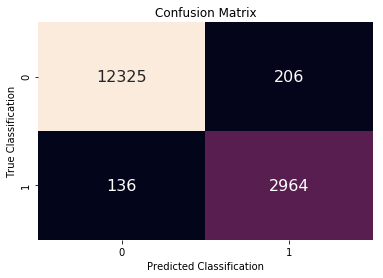

In [76]:
ax = sb.heatmap(cMatrix, annot=True, fmt="d",annot_kws={"size": 16}, cbar=False);
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Classification');
ax.set_ylabel('True Classification');

In [77]:
# Precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

pd.DataFrame([[scores[1],precision,recall,f1]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])

,Accuracy,Precision,Recall,F1-score
LSTM,0.97812,0.935016,0.956129,0.945455


### Using Test Set ###
Aqui é usado o conjunto de dados de teste para validação de aprendizado do modelo.

In [78]:
# generate sequences
sequenceTest = [testData[testData['id']==id][seqFeatures].values[-windowSize:] 
                       for id in testData['id'].unique() if len(testData[testData['id']==id]) >= windowSize]

sequenceTest = np.asarray(sequenceTest).astype(np.float32)

In [79]:
yMask = [len(testData[testData['id']==id]) >= windowSize for id in testData['id'].unique()]

In [80]:
# generate classification labels
classGenTest = testData.groupby('id')['classification'].nth(-1)[yMask].values
classGenTest = classGenTest.reshape(classGenTest.shape[0],1).astype(np.float32)

In [81]:
scoresTest = model.evaluate(sequenceTest, classGenTest, verbose=2)

In [82]:
# Confusion matrix
y_pred_test = model.predict_classes(sequenceTest)
y_true_test = classGenTest
cMatrix_test = confusion_matrix(y_true_test, y_pred_test)

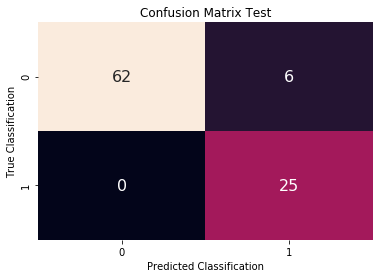

In [83]:
ax = sb.heatmap(cMatrix_test, annot=True, fmt="d",annot_kws={"size": 16}, cbar=False);
ax.set_title('Confusion Matrix Test');
ax.set_xlabel('Predicted Classification');
ax.set_ylabel('True Classification');

In [84]:
# Precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)

pd.DataFrame([[scoresTest[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])

,Accuracy,Precision,Recall,F1-score
LSTM,0.935484,0.806452,1.0,0.892857


### Prediction Plot ###

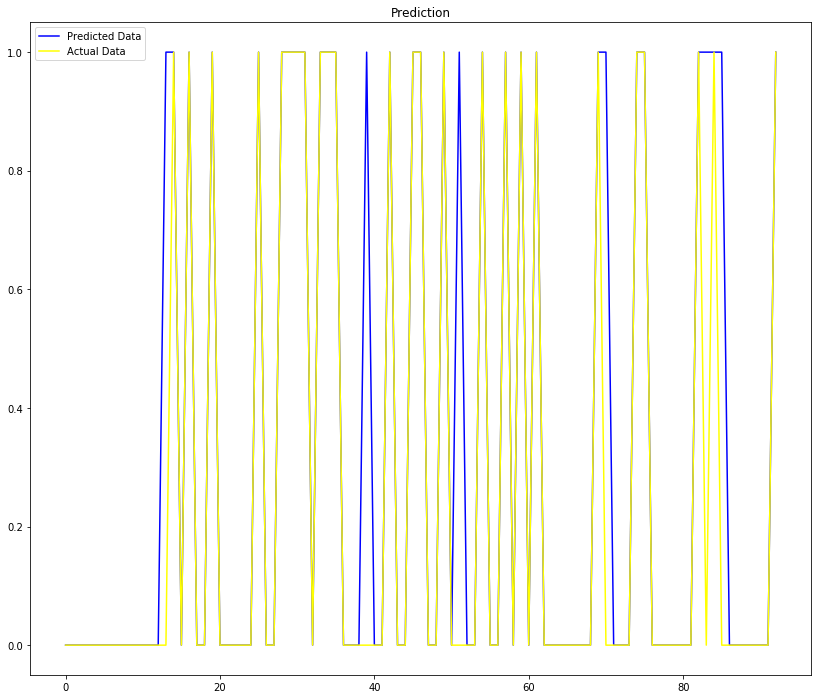

In [85]:
plt.figure(figsize=(14, 12))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="yellow")
plt.title('Prediction')
plt.legend(['Predicted Data', 'Actual Data'], loc='upper left')
plt.show()

### Model Loss ###

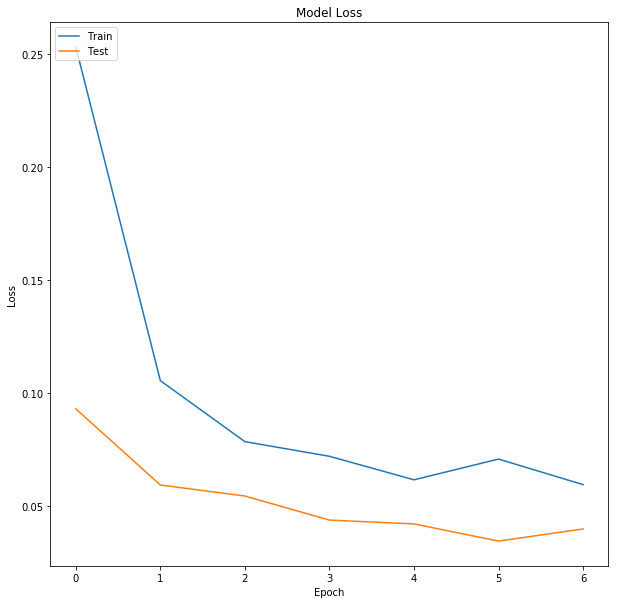

In [95]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Model Accuracy ###

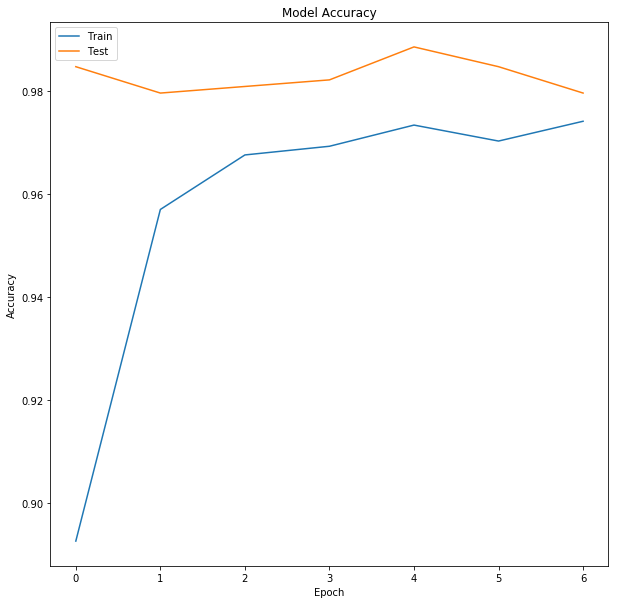

In [100]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()